In [125]:
import h5py
import plotting_func
import calculations

To calculate the emissivity in each bin, use the formula

$\Delta I_{\nu}^{\textrm{voxel}\ n,k}  = \tau_{353}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) 
= \rho_{353}^{k} \Delta E_{\textrm{B-V}}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) E_{\textrm{B-V}}^{n,k}$

where $k$ is indexing over the pixels in the sky, and $n$ is indexing over the distance bins



In [126]:
#File containing all data (make sure to change this to your directory)
filename="/fs/lustre/cita/molinaca/All_data_3D_temperature_17_dist_bins_nside_128.hdf5"

#Path to store images, change for your directory
image_path ="/fs/lustre/cita/molinaca/Images"

In [127]:
#Function to load the data from the hdf5 file
def load_3D_temperature_data(file):
    data_dict = {}
    with h5py.File(file, "r") as g:    
        data_dict["temperatures"]=g["temperature"][()] # this is (healpix x distance_bin)
        data_dict["distance_slices"] = g["distance_slices"][()]
        data_dict["dEBV"] = g["dEBV_smooth"][()]
        data_dict["rhos"] = g["rhos"][()] 
        data_dict["betas"]= g["betas"][()]
        data_dict["nside"] = g.attrs["nside"]
        data_dict["nr_of_distance_bins"] = g.attrs["nr_of_distance_bins"]
        data_dict["healpix_ordering"] = g.attrs["healpix_ordering"] #nest
        data_dict["run_name"] = g.attrs["original_run_name"]
        g.close()
    return data_dict


## Creating map of density x temperature
This part of the code contains the steps required to create a density x temperature map of the sky. It includes increasing the resolution of the temperature map, converting that to temperature emissivity and multiplying that by dEBV. 

### Create new temperature map with resolution that matches dEBV map
The temperature map has an nside of 128, but dEBV has an nside of 1024, in order to multiply these the resolution of the temperature map has to be increased. 

In [128]:
#Load all maps
data_dict=load_3D_temperature_data(filename)

In [129]:
#Define  Ts, dEBV and increase resolution of Ts

#Define dEBV and clip it due to negative values
dEBV = data_dict["dEBV"]
dEBV = np.clip(dEBV, 0, None)

##Get nside of the temperature and density maps
Ts = data_dict["temperatures"] #Original temperature map, defining for ease of use

print("Temperature resolution:", hp.get_nside(Ts[:,0]))
print("E(B-V) resolution:", hp.get_nside(dEBV[0]))

##Increase resolution of temperature map to 1024
Ts_new = increase_temp_res(data_dict, 1024)
                                  
#Some checks to make sure everything is working
print("New temperature resolution:", hp.get_nside(Ts_new[0]))

print("Shape of original temperature map:", Ts.shape)
print("Shape of new temperature map:", Ts_new.shape)

print("Original temperature array:\n", Ts)
print("New temperature array:\n", Ts_new)


Temperature resolution: 128
E(B-V) resolution: 1024
New temperature resolution: 1024
Shape of original temperature map: (196608, 17)
Shape of new temperature map: (17, 12582912)
Original temperature array:
 [[18.800053  16.870003  15.337718  ...  5.        14.146356  26.819225 ]
 [18.789234  19.42068   18.598013  ... 19.548403  19.369473  16.124052 ]
 [19.040045  18.37719   22.935205  ... 18.276548   7.277836  18.685047 ]
 ...
 [26.139109  17.511135  25.047724  ... 24.625113   6.7835207 10.880443 ]
 [18.800133  18.800201  18.799892  ... 18.799957  18.799862  18.799978 ]
 [18.80004   18.79939   18.80011   ... 18.800066  18.799824  18.799965 ]]
New temperature array:
 [[18.80005264 18.80005264 18.80005264 ... 18.80003929 18.80003929
  18.80003929]
 [16.87000275 16.87000275 16.87000275 ... 18.79939079 18.79939079
  18.79939079]
 [15.33771801 15.33771801 15.33771801 ... 18.80010986 18.80010986
  18.80010986]
 ...
 [ 5.          5.          5.         ... 18.80006599 18.80006599
  18.800065

In [130]:
#Plotting temperature map with new resolution
#plot_map(data_dict, Ts_new, 10, 25, 'New Temperature Map', 'K')

### Get temperature emission and frequencies
Use Wien's law for 3 given temperatures (that will correspond to each color channel) to get the maximum frequency for each. Use this with the planck function to create temperature emissivity maps at each frequency. 

In [131]:
#Calculate frequencies
freq1 = WiensLaw(10) 
freq2 = WiensLaw(18.8)
freq3 = WiensLaw(30)

frequency = [freq1, freq2, freq3] #make array of frequencies in Hz, will be used in calculations
freq_ghz = [freq1*1e-9, freq2*1e-9, freq3*1e-9] #Change to GHz for printing only
print(freq_ghz)

[588.4261240427707, 1106.241113200409, 1765.2783721283122]


In [132]:
##Get new maps by taking the planck function at each frequency    
planck_maps = np.zeros((len(frequency), Ts_new.shape[0], Ts_new.shape[1])) #Create array to store the planck maps
for i in range(len(frequency)):
    planck_maps[i] = Planck(frequency[i], Ts_new)


In [133]:
#Plotting planck functions
min_planck = [1e-17, 4e-16, 3e-21] #Get minimum for each for better visibility
max_planck = 2e-15 #They all have the same maximum
unit_planck = r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$'

#plot_map(data_dict, planck_maps[0], min_planck[0], max_planck, f'$B$ for {int(freq_ghz[0])} GHz', unit_planck)
#plot_map(data_dict, planck_maps[1], min_planck[1], max_planck, f'$B$ for {int(freq_ghz[1])} GHz', unit_planck)
#plot_map(data_dict, planck_maps[2], min_planck[2], max_planck, f'$B$ for {int(freq_ghz[2])} GHz', unit_planck)

### Multiply dEBV and B maps

In [134]:
dens_temp = multiply_dEBVandB(data_dict, dEBV, planck_maps, frequency)
dens_temp_norm = normalize_dEBVandB(data_dict, dens_temp, frequency)

In [135]:
#Plotting density times temperature maps
min_dxT = 0 #all have the same minimum
max_dxT = [5e-16, 7e-16, 6e-16]
unit_dxT = r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$' #same units as planck function

#plot_map(data_dict, dens_temp[0], min_dxT, max_dxT[0], f"$B$ and $E(B-V)$ for {int(freq_ghz[0])} GHz", unit_dxT)
#plot_map(data_dict, dens_temp[1], min_dxT, max_dxT[1], f"$B$ and $E(B-V)$ for {int(freq_ghz[1])} GHz", unit_dxT)
#plot_map(data_dict, dens_temp[2], min_dxT, max_dxT[2], f"$B$ and $E(B-V)$ for {int(freq_ghz[2])} GHz", unit_dxT)



In [136]:
#How you would plot normalized densxtemp map but haven't actually seen what the max should be

#plot_map(data_dict, dens_temp_norm[0], 0, 1, f"Normalized $B$ and $E(B-V)$ for {int(freq_ghz[0])} GHz", None)
#plot_map(data_dict, dens_temp_norm[1], 0, 1, f"Normalized $B$ and $E(B-V)$ for {int(freq_ghz[1])} GHz", None)
#plot_map(data_dict, dens_temp_norm[2], 0, 1, f"Normalized $B$ and $E(B-V)$ for {int(freq_ghz[2])} GHz", None)

In [137]:
#Calculate difference of dEBV and new map with temperature
dEBV_diff = {}

for f_index in range(3):
    dEBV_diff[f_index] = np.zeros((data_dict['nr_of_distance_bins'], len(planck_maps[0, 0])))
    for ds_index in range(data_dict['nr_of_distance_bins']):
        dEBV_diff[f_index, ds_index] = dens_temp_norm[f_index, ds_index] - dEBV[ds_index]

# for ds_index in range(model_nslices):
#     hp.mollview(dEBV_diff[0, ds_index], title=r"$B$ and $E(B-V)$ for 588 GHz at distance slice 0",nest=True, min = -1, max = 1, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

## Create RGB Images
This code creates RGB images of Cepheus, Orion A & B and the whole sky. It also creates panels

In [138]:
#Set up global RGB arrays that will be used in other cells
R, G, B = get_RGB(dens_temp_norm)

### Looking at the Cepheus Local Molecular Cloud

In [139]:
#Pick section of LMC Cepheus

d_ceph = 3 #is at distance slice 3
l_ceph = 112.1 #l and b obtained from Zucker et al 2021
b_ceph = 15.9

#Parameters that would be used in hp.gnomview
x_ceph = 2000
y_ceph = 2000
min_ceph = 0
max_ceph = 0.09 #max that produces best contrast

#for fs_index in range(len(frequency)):
#    plot_map_region(dens_temp_norm[fs_index, d_ceph], l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, max_ceph, f"Normalized $B$ and $E(B-V)$ of the Cepheus Molecular Cloud at {int(freq_ghz[fs_index])} GHz", None)

In [140]:
#Pick a path to store all images related to Cepheus
cepheus_path = os.path.join(image_path, "Cepheus")

R_ceph, G_ceph, B_ceph, RGB_ceph = get_region_image(R, G, B, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, scale=True)
RGB_ceph.save(cepheus_path + "/ceph_rgb_scaled.png")

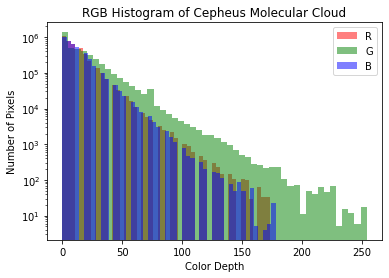

In [110]:
#Looking at histogram and gnomview of color depth of each channel

#Plotting the histograms of flattened RGB arrays
plot_RGB_histogram(R_ceph, G_ceph, B_ceph, "RGB Histogram of Cepheus Molecular Cloud", cepheus_path + "/ceph_rgb_hist_scaled.png")

#Plotting the color depth of each channel but with gnomview
# plot_map_region(R, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, None, 'Cepheus LMC in R Color Channel', r'Color Depth')
# plt.savefig(cepheus_path + "/ceph_R.png")
# plot_map_region(G, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, None, 'Cepheus LMC in G Color Channel', r'Color Depth')
# plt.savefig(cepheus_path + "/ceph_G.png")
# plot_map_region(B, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, None, 'Cepheus LMC in B Color Channel', r'Color Depth')
# plt.savefig(cepheus_path + "/ceph_B.png")


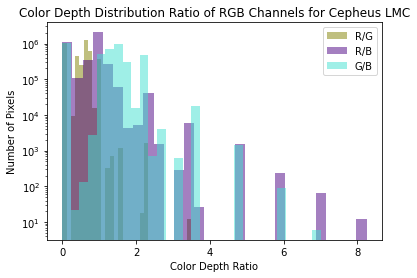

In [111]:
ceph_ratio_RG, ceph_ratio_RB, ceph_ratio_GB = get_rgb_ratios(R_ceph, G_ceph, B_ceph, "Color Depth Distribution Ratio of RGB Channels for Cepheus LMC", cepheus_path + "/ceph_rgb_hist_ratios.png")

In [112]:
#Make dictionary that encompasses all maps to make it easier to make panels

maps_dict = {
    'Temp_og' : Ts,
    'Temp_new' : Ts_new,
    'Density' : dEBV,
    'Planck' : planck_maps,
    'Normalized_denstemp' : dens_temp_norm
}


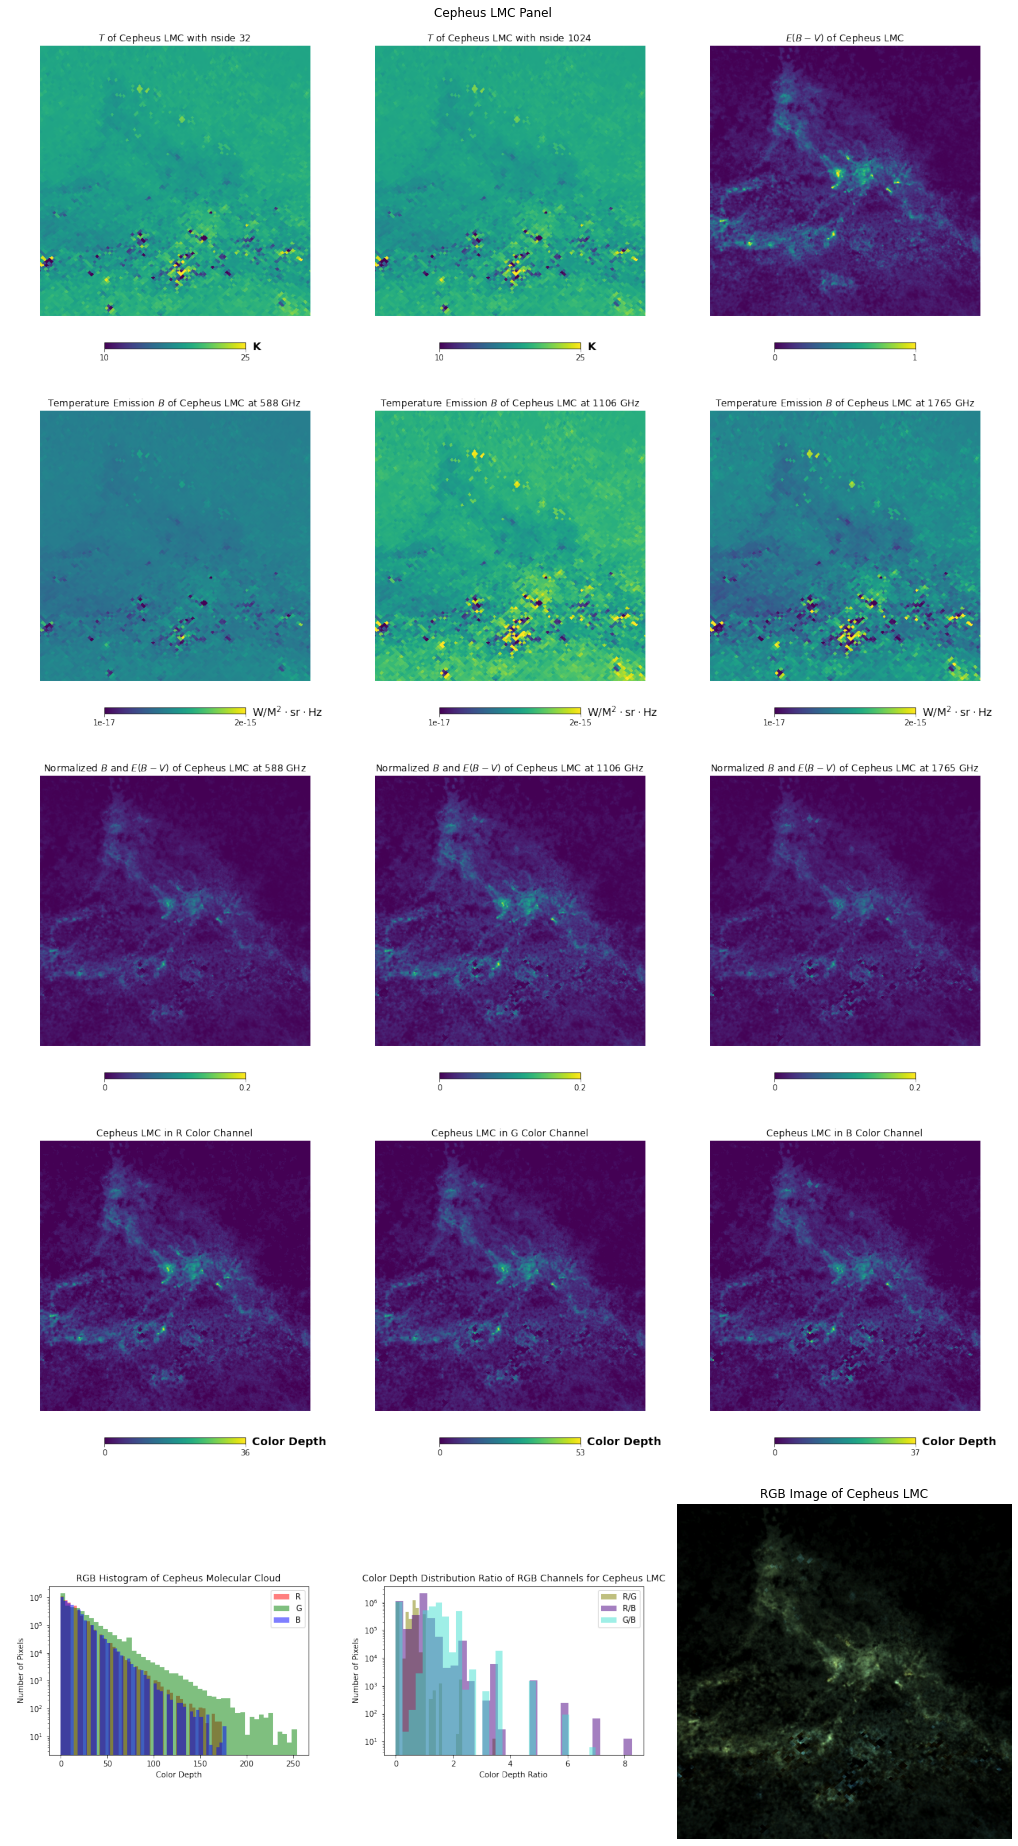

In [113]:
create_panel(maps_dict, freq_ghz, d_ceph, l_ceph, b_ceph, "Cepheus LMC", cepheus_path + "/ceph_")

### Looking at Orion A and B Molecular Clouds

In [114]:
#Just looking at what Orion A and B look like with density x temperature map at diff frequencies
l_orionB = 205.5
b_orionB = -14
d_orionB = 4 #At distance slice 4

#Parameters that would be used in hp.gnomview
x_orion = 2000
y_orion = 2000
min_orion = 0
max_orion = 0.3 #max that produces best contrast

#Plotting to see what it looks like at each frequency
#for fs_index in range(len(frequency)):
#    plot_map_region(dens_temp_norm[fs_index], d_orionB, l_orionB, b_orionB, x_orion, y_orion, min_orion, max_orion, f'Normalized $B$ and $E(B-V)$ of Orion B at {int(freq_ghz[fs_index])} GHz', None)

In [115]:
orion_path = os.path.join(image_path, "Orion")
R_orion, G_orion, B_orion, RGB_orion = get_region_image(R, G, B, d_orionB, l_orionB, b_orionB, x_orion, y_orion, scale=True)
RGB_orion.save(orion_path + "/orion_rgb_scaled.png")

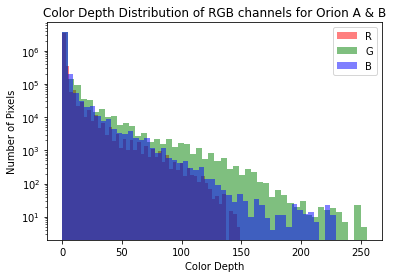

In [121]:
plot_RGB_histogram(R_orion, G_orion, B_orion, "Color Depth Distribution of RGB channels for Orion A & B", orion_path + "/orion_rgb_hist_scaled.png")

# plot_map_region(R, d_orionB, l_orionB, b_orionB, x_orion, y_orion, min_orion, None, 'Orion A & B in R Color Channel', r'Color Depth')
# plt.savefig(orion_path + "/orion_R.png")
# plot_map_region(G, d_orionB, l_orionB, b_orionB, x_orion, y_orion, min_orion, None, 'Orion A & B in G Color Channel', r'Color Depth')
# plt.savefig(orion_path + "/orion_G.png")
# plot_map_region(B, d_orionB, l_orionB, b_orionB, x_orion, y_orion, min_orion, None, 'Orion A & B in B Color Channel', r'Color Depth')
# plt.savefig(orion_path + "/orion_B.png")

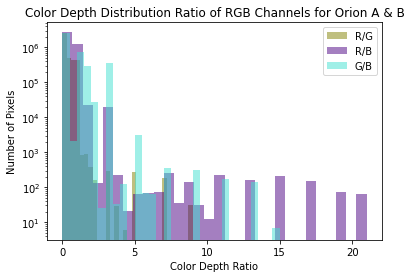

In [123]:
orion_ratio_RG, orion_ratio_RB, orion_ratio_GB = get_rgb_ratios(R_orion, G_orion, B_orion, "Color Depth Distribution Ratio of RGB Channels for Orion A & B", orion_path + "/orion_rgb_hist_ratios.png")

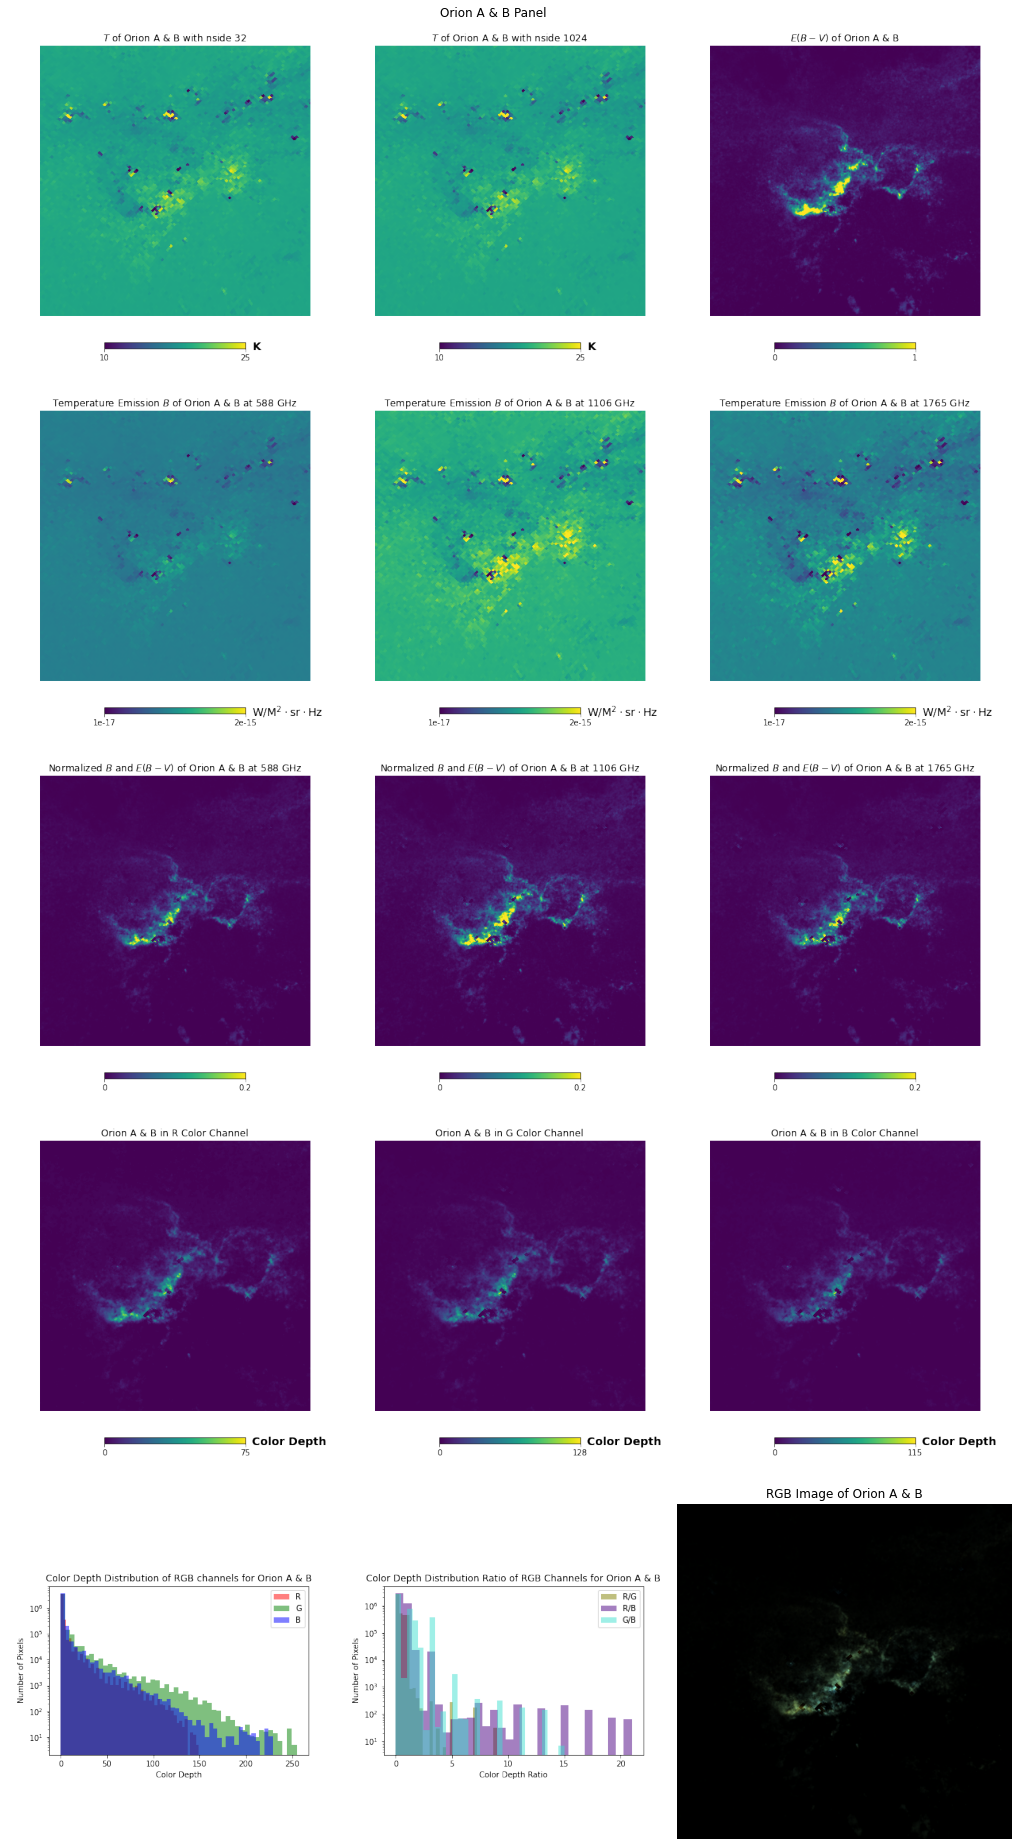

In [124]:
create_panel(maps_dict, freq_ghz, d_orionB, l_orionB, b_orionB, "Orion A & B", orion_path + "/orion_")

### Creating RGB Image of Whole Sky

In [79]:
get_sky_image(data_dict, R, G, B, scale=True)

In [81]:
allsky_path = os.path.join(image_path, "AllSky")

#for ds_index in range(data_dict["nr_of_distance_bins"]):
    #plot_RGB_histogram(R[ds_index], G[ds_index], B[ds_index], f"Color Channel Distributions of Whole sky at Distance Slice {ds_index}", allsky_path + f"/allsky_rgb_hist_{ds_index}.png")

In [85]:
#Making hp.mollview plots of each color channel for the whole sky
#plot_map(data_dict, R, 0, 255, f"R Channel at Distance Slice {ds_index}", r'Color Depth')
#plot_map(data_dict, G, 0, 255, f"G Channel at Distance Slice {ds_index}", r'Color Depth')
#plot_map(data_dict, B, 0, 255, f"B Channel at Distance Slice {ds_index}", r'Color Depth')

In [ ]:
#plot_3D_temperature_slice_maps(data_dict)